<a href="https://colab.research.google.com/github/bigirimanainnocent12/S-rie-temporelle/blob/main/LSTM_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import random

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2

# **Exercice 1: Prédiction d'une série temporelle pas LSTM**

On considère un jeu donnant le nombre de passagers aériens entre janvier 1949 et décembre 1960 (https://www.kaggle.com/datasets/rakannimer/air-passengers)

Le code suivant permet d'apprendre un réseau de type LSTM qui permet de prédire le nombre de passager du mois suivant à partir de ceux de l'année précédente. Comprendre chacun des blocs de code, et compléter la définition du lstm. Apprendre les poids du réseau.

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")

print("Path to dataset files:", path)

data=pd.read_csv(path+"/AirPassengers.csv")
data.head()


Path to dataset files: /root/.cache/kagglehub/datasets/rakannimer/air-passengers/versions/1


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


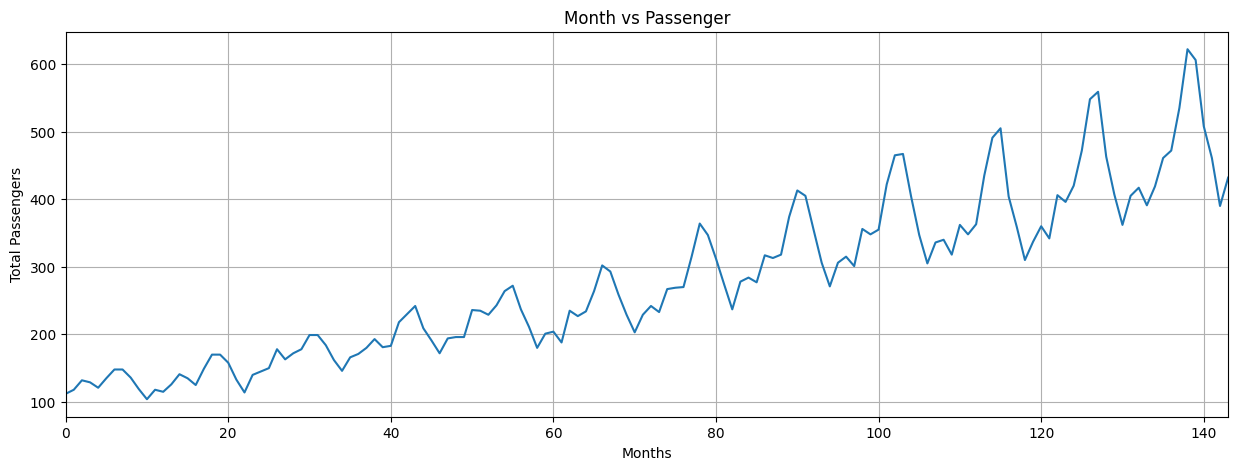

In [26]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['#Passengers'])

In [27]:
all_data = data['#Passengers'].values.astype(float)
all_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [28]:
test_data_size = 24

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [30]:
print(train_data[:5,])
print(train_data_normalized[:5,])

[112. 118. 132. 129. 121.]
[[-0.96009975]
 [-0.93017456]
 [-0.86034913]
 [-0.87531172]
 [-0.91521197]]


In [31]:
train_data_normalized = torch.FloatTensor(train_data_normalized)
train_data_normalized

tensor([[-0.9601],
        [-0.9302],
        [-0.8603],
        [-0.8753],
        [-0.9152],
        [-0.8454],
        [-0.7805],
        [-0.7805],
        [-0.8404],
        [-0.9252],
        [-1.0000],
        [-0.9302],
        [-0.9451],
        [-0.8903],
        [-0.8155],
        [-0.8454],
        [-0.8953],
        [-0.7756],
        [-0.6708],
        [-0.6708],
        [-0.7307],
        [-0.8554],
        [-0.9501],
        [-0.8204],
        [-0.7955],
        [-0.7706],
        [-0.6309],
        [-0.7057],
        [-0.6608],
        [-0.6309],
        [-0.5262],
        [-0.5262],
        [-0.6010],
        [-0.7107],
        [-0.7905],
        [-0.6908],
        [-0.6658],
        [-0.6209],
        [-0.5561],
        [-0.6160],
        [-0.6060],
        [-0.4314],
        [-0.3716],
        [-0.3117],
        [-0.4763],
        [-0.5661],
        [-0.6608],
        [-0.5511],
        [-0.5411],
        [-0.5411],
        [-0.3416],
        [-0.3466],
        [-0.

In [32]:
train_window = 12

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

train_inout_seq[:5]

[(tensor([[-0.9601],
          [-0.9302],
          [-0.8603],
          [-0.8753],
          [-0.9152],
          [-0.8454],
          [-0.7805],
          [-0.7805],
          [-0.8404],
          [-0.9252],
          [-1.0000],
          [-0.9302]]),
  tensor([[-0.9451]])),
 (tensor([[-0.9302],
          [-0.8603],
          [-0.8753],
          [-0.9152],
          [-0.8454],
          [-0.7805],
          [-0.7805],
          [-0.8404],
          [-0.9252],
          [-1.0000],
          [-0.9302],
          [-0.9451]]),
  tensor([[-0.8903]])),
 (tensor([[-0.8603],
          [-0.8753],
          [-0.9152],
          [-0.8454],
          [-0.7805],
          [-0.7805],
          [-0.8404],
          [-0.9252],
          [-1.0000],
          [-0.9302],
          [-0.9451],
          [-0.8903]]),
  tensor([[-0.8155]])),
 (tensor([[-0.8753],
          [-0.9152],
          [-0.8454],
          [-0.7805],
          [-0.7805],
          [-0.8404],
          [-0.9252],
          [-1.0000]

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq) ,1, -1))
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [34]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.03024825
epoch:  26 loss: 0.00051071
epoch:  51 loss: 0.00226908
epoch:  76 loss: 0.00007823
epoch: 101 loss: 0.00011688
epoch: 126 loss: 0.00541126
epoch: 149 loss: 0.0002698653


RMSE: 122.56372799131246


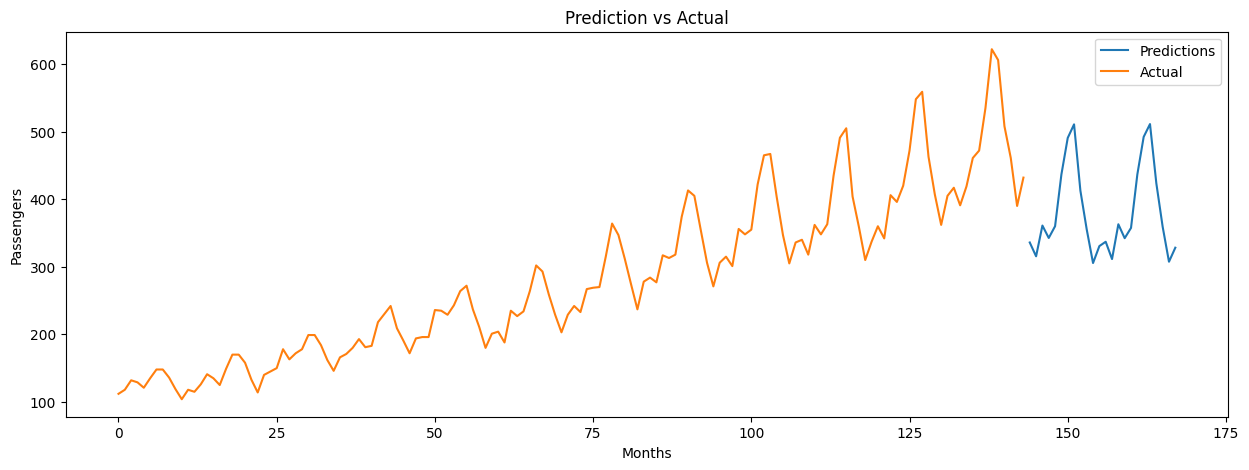

In [36]:
# prompt: Prédire le nombre de passagers par mois dans les deux dernières années (qui ont été retirées du jeu d'apprentissage). Comparer à la réalité de ce qui a été observé. mettrez RMSE ET LE PLOT

import numpy as np

# Test data normalization
test_data_normalized = scaler.transform(test_data.reshape(-1, 1))
test_data_normalized = torch.FloatTensor(test_data_normalized)

# Prediction
fut_pred = 24
preds = []

# Initial sequence for prediction
model.eval()
with torch.no_grad():
    test_inputs = train_data_normalized[-train_window:].tolist()  # Get initial sequence
    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])  # Create tensor from sequence
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            pred = model(seq)

        # Append the prediction as a list to maintain the structure of test_inputs
        test_inputs.append([pred.item()])

        preds.append(pred.item())

# Inverse transform to get actual values
actual_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(np.mean((actual_predictions - test_data) ** 2))
print(f"RMSE: {rmse}")

# Plotting
x = np.arange(len(all_data), len(all_data) + len(actual_predictions))
plt.plot(x, actual_predictions, label='Predictions')
plt.plot(np.arange(len(all_data)), all_data, label='Actual')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.title('Prediction vs Actual')
plt.legend()
plt.show()